<h1 align="center">Investigating Bandgaps Using Machine Learning</h1>

## Preparing the Dataset

This dataset is provided in [Predicting the Band Gaps of Inorganic Solids by Machine Learning](http://dx.doi.org/10.1021/acs.jpclett.8b00124). Minimal processing has been carried out on the provided dataset to make it applicable for use in this example.

Here we will look at both regression and binary classification and so we need supervised target values for both cases; with regression this is simply the bandgap of the material (in eV), for the classication case we can make a binary split in a straightforward manner as the conductors reported in the dataset are quoted with bandgaps of zero.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

bandgap_dataset = pd.read_csv("bandgap-example.csv")

_, compositions, y_reg = bandgap_dataset.T.values

y_clf = np.where(y_reg == 0, 0, 1)

N = y_clf.shape[0]
N_gap = y_clf.sum()
N_cond = N - N_gap
print("The total number of samples is {} of which {}"
      " are conductors and {} have bandgaps".format(N, N_cond, N_gap))

The total number of samples is 5116 of which 1980 are conductors and 3136 have bandgaps


Here we see that we have a dataset that is biased towards materials with bandgaps. This is left as something for further exploration.

Now we will use `magpy` to get our features; we can use any of the matscholar, megnet, cgcnn, elem or elem_low embeddings in the notebook folder. 

In [6]:
import magpy

X = magpy.core.descriptors(compositions, embedding_file="elem_embedding.json",
                            operations = ["wmean", "wstd", "max", "min"])

As we have installed `magpy` with an editable source (via -e flag) you can add further operations by editting the Statistics Class in core. Currently the availiable operations are: 'wmean', 'wstd', 'max', 'min', 'range', 'harmonic', 'geometric', and 'sum'.

## Building a simple classifier

Here we will build a simple classification model using a Support Vector Machine Classification as done in the reference paper. 

There are several housekeeping steps we need to undertake:

1. Splitting the data into independent Training and Test sets.
2. Scaling the input features in order to improve the optimisation performance

The model is used as an out of the box implementation from the scikit-learn library where we just take the default values for the model hyper-parameters.

The models performance can be examined using the ROC Curve as well as the Precision, Recall and F1 metrics. Note that we get two values for Precision, Recall and F1 metrics depending on whether we are using the model to pick out Metals or Non-Metals, the difference is related to the dataset bias.

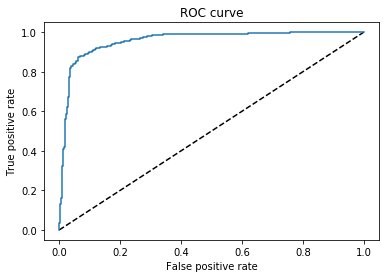

The ROC-AUC score is 0.9571431411135626 
The Precision score is [0.90106952 0.88923077] 
The Recall score is [0.82396088 0.9398374 ] 
The F1 score is [0.86079183 0.91383399]


In [8]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_clf, test_size=0.2)

# Scale the input features to improve
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

# Define and fit the model
clf = SVC(probability=True, gamma='scale').fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Evaluate the performance vs target values
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc_ = auc(fpr, tpr)
pre, re, f1, sup = precision_recall_fscore_support(y_test, y_pred)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

print("The ROC-AUC score is {} \n"
      "The Precision score is {} \n"
      "The Recall score is {} \n"
      "The F1 score is {}".format(auc_, pre,re,f1))

## Building a Simple Regressor

Now we use a Support Vector Machine Regressor to see if we can predict the bandgap of the non-metals in the dataset. Again we undertake the same housekeeping steps as before. 

The model is used as an out of the box implementation from the scikit-learn library where we just take the default values for the model hyper-parameters.

The models performance can be examined using the $R^2$ and Root Mean Squared Error (RMSE).

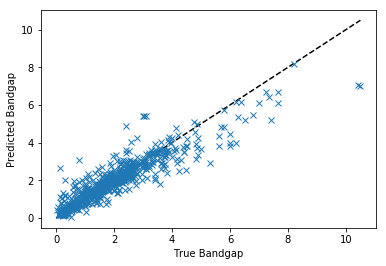

The R2 Score is 0.8334578642712752
The RMSE is 0.6052856140894248 eV


In [11]:
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_squared_error

# Select only non-metal data
X_reg = X[np.nonzero(y_reg)]
y_reg = y_reg[np.nonzero(y_reg)]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2)

# Scale the input features to improve
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

# Define and fit the model
reg = SVR(gamma='scale').fit(X_train, y_train)

# Make predictions on the test set
y_pred = reg.predict(X_test)

# Evaluate the performance vs target values
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

max_ = np.max([y_test.max(), y_pred.max()])

plt.figure()
plt.plot([0, max_], [0, max_], 'k--')
plt.plot(y_test, y_pred, 'x')
plt.xlabel('True Bandgap')
plt.ylabel('Predicted Bandgap')
plt.show()

print("The R2 Score is {}".format(r2))
print("The RMSE is {} eV".format(rmse))

## Ideas to work on

* resample the dataset to address class imbalance how does this affect the classification question
* carry out hyper-parameter optimisation to try improve model performance
* try other models from the sci-kit learn library and see if they perform better, as a starting point you might consider:
    1. random forests,
    2. gaussian processes,
    3. naive bayes classifiers.
* experiment with the different embeddings and compare their performance with eachother